In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# 决策树的生成
本例以CART算法构造树。

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

## 度量一次分割的好坏

选哪个特征及特征值作为分割点来下刀？2个判定指标：
1. 基尼不纯度（基尼杂质率）
2. 信息增益

## 基尼不纯度
整个数据集的不纯度：
![Gini](Gini.png)

二分类的基尼不纯度：

(0, 1)

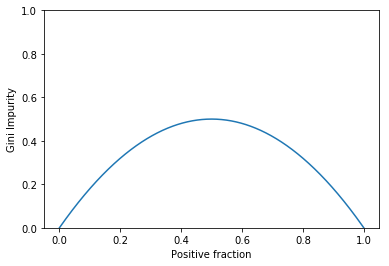

In [3]:
pos_fraction = np.linspace(0.00, 1.00, 1000)   # 正类概率范围0-1
gini = 1 - pos_fraction**2 - (1-pos_fraction)**2
plt.plot(pos_fraction, gini)
plt.xlabel('Positive fraction')
plt.ylabel('Gini Impurity')
plt.ylim(0,1)
plt.show()

给定数据集，基尼不纯度计算函数：

In [4]:
labels = [1,1,0,1,0]
np.unique(labels, return_counts=True)
counts = np.unique(labels, return_counts=True)[1]
fractions = counts/float(len(labels))
fractions

(array([0, 1]), array([2, 3]))

array([ 0.4,  0.6])

In [5]:
np.sum(fractions ** 2)

0.52000000000000002

In [6]:
1 - np.sum(fractions**2)

0.47999999999999998

In [7]:
def gini_impurity(labels):
    if not labels:    # 当数据集为空，也是纯的
        return 0  
    counts = np.unique(labels, return_counts=True)[1] # 统计每个label的频数
    fractions = counts/ float(len(labels))
    return 1 - np.sum(fractions ** 2)
print('{0:.4f}'.format(gini_impurity([1,1,0,1,0])))
print('{0:.4f}'.format(gini_impurity([1,1,0,1,0,0])))
print('{0:.4f}'.format(gini_impurity([1,1,1,1])))

0.4800
0.5000
0.0000


### 评估拆分的质量，
我们只需将所有子分组的基尼杂质率相加，然后将每个子分组的占比作为相应的权重因子。

Gini杂质的加权和越小，分割就越好。

![self-car ad](example.png)
![#1](gini1.png)
![#2](gini2.png)

所以，选择“兴趣”feature来分裂更好

## 信息增益
另一个度量指标是Information Gain，度量分裂后的纯度提升，也就是分裂后uncertainty的下降。信息增益越高，说明分裂得越好。涉及到“熵”
### 熵
熵是一个概率值，度量数据集的uncertainty。熵越小，数据集越纯，越有序。一个数据集的熵定义如下：
![entropy](entropy.png)

熵越小，数据集的纯度越高。
    
    最理想的，数据集只有1个类，entropy = -（1 x log2 1 + 0) = 0;
    抛硬币为例，entropy = - (0.5 x log2 0.5 + 0.5 x log2 0.5) = 1

二分类，不同正类fraction值下的熵变化图：

/Users/linzhun/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app
/Users/linzhun/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


(0, 1)

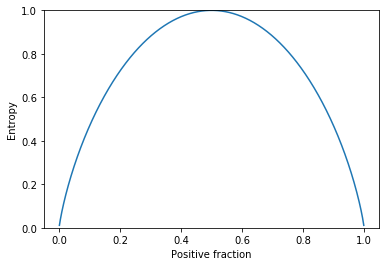

In [8]:
pos_fraction = np.linspace(0.00, 1.00, 1000)
ent = - (pos_fraction * np.log2(pos_fraction) + (1 - pos_fraction)*np.log2(1-pos_fraction))
plt.plot(pos_fraction, ent)
plt.xlabel('Positive fraction')
plt.ylabel('Entropy')
plt.ylim(0,1)
plt.show()

给定labels数据集，计算熵

In [9]:
def entropy(labels):
    if not labels:
        return 0
    counts = np.unique(labels,return_counts=True)[1]
    fractions = counts / float(len(labels))
    return - np.sum(fractions * np.log2(fractions))

print('{0:.4f}'.format(entropy([1,1,0,1,0])))
print('{0:.4f}'.format(entropy([1,1,0,1,0,0])))
print('{0:.4f}'.format(entropy([1,1,1,1])))

0.9710
1.0000
-0.0000


### 信息增益计算分裂后uncertainty 下降了多少：
分裂前后的熵差：
    
    InformationGain = Entropy(before) - Entropy(after) 
                    = Entropy(parent) - Entropy(children)
                    
**Entropy(after) 是每个entropy(child) 的加权和**

构建树的一个节点时，我们的目标是找一个分裂点（feature）使得信息增益最大。因为entropy(parent)不变，我们只需计算该分裂后的entropy(children)。**entropy(children) 越小，这个分裂越好。**

![self-driving car](example.png)
![entropy1](entropy1.png)
![entropy2](entropy2.png)
![informationgain](inforgain.png)

第2个分裂更好

### 通常，2个度量的效果差不多，都是子节点不纯度的加权和。
我们可以把它们整合到一个函数里：计算子节点的不纯度加权和

In [17]:
criterion_function = {'gini':gini_impurity,
                      'entropy': entropy}
def weighted_impurity(groups, criterion='gini'):
    """Calculate weighted impurity of children after a split
    Args:
        groups (list of children, and a child consist a list of class labels)
        criterion (metric to messure the quality of a split, 'gini' for Gini Impurity
                   or 'entropy' for Information Gain)
    Return:
        float, weighted impurity
    """
    total = sum(len(group) for group in groups)
    weighted_sum = 0.0
    for group in groups:
        weighted_sum += len(group)/ float(total) *criterion_function[criterion](group)
    return weighted_sum

In [18]:
children1 = [[1,0,1],[0,1]]
children2 = [[1,1],[0,0,1]]
print('Entropy of #1 split: {0:.4f}'.format(weighted_impurity(children1,'entropy')))
print('Entropy of #2 split: {0:.4f}'.format(weighted_impurity(children2,'entropy')))

Entropy of #1 split: 0.9510
Entropy of #2 split: 0.5510


## 理解了如何分裂，下面实操用CART算法来生成一棵树：
给定数据集![practice](practice_data.png)

### 首先，确定第一个分裂点，也就是根节点。尝试每个特征可能的值：

In [113]:
d = dict(gini_interest_Tech = weighted_impurity([[1,1,0],[0,0,0,1]]),
gini_interest_Fashion = weighted_impurity([[1,0,1,0,1],[0,0]]),
gini_interest_Sports = weighted_impurity([[1,0,0,1,0],[0,1]]),
gini_occupation_Professional = weighted_impurity([[1,0,1],[0,0,1,0]]),
gini_occupation_Student = weighted_impurity([[1,0,0,1],[0,0,1]]),
gini_occupation_Retired = weighted_impurity([[1,0,0,0,1,1],[0]]))
d
s1 = pd.Series(d)
s1.sort_values()

{'gini_interest_Fashion': 0.34285714285714286,
 'gini_interest_Sports': 0.48571428571428571,
 'gini_interest_Tech': 0.40476190476190477,
 'gini_occupation_Professional': 0.40476190476190477,
 'gini_occupation_Retired': 0.42857142857142855,
 'gini_occupation_Student': 0.47619047619047616}

gini_interest_Fashion           0.342857
gini_interest_Tech              0.404762
gini_occupation_Professional    0.404762
gini_occupation_Retired         0.428571
gini_occupation_Student         0.476190
gini_interest_Sports            0.485714
dtype: float64

选择特征interest，特征值为Fashion 作为根节点，我们可以生成第一层树：![first_level](first_level.png)

如果“一层“树就够了，我们可以到此为止，指定左枝为label 1，右枝为label 0 即可。

### 当然，我们可以通过左枝继续生成第二层树，右枝已不可分：

In [114]:
d2 = dict(gini_interest_Tech2 = weighted_impurity([[1,1,0],[0,1]]),
          gini_interest_Sports2 = weighted_impurity([[1,1,0],[0,1]]),
          gini_occupation_Professional2 = weighted_impurity([[1,1],[0,1,0]]),
          gini_occupation_Retired2 = weighted_impurity([[0],[1,0,1,1]]),
          gini_occupation_Student2 = weighted_impurity([[1,0,1],[0,1]]))

d2
s2 = pd.Series(d2)
s2.sort_values()

{'gini_interest_Sports2': 0.46666666666666667,
 'gini_interest_Tech2': 0.46666666666666667,
 'gini_occupation_Professional2': 0.26666666666666666,
 'gini_occupation_Retired2': 0.30000000000000004,
 'gini_occupation_Student2': 0.46666666666666667}

gini_occupation_Professional2    0.266667
gini_occupation_Retired2         0.300000
gini_interest_Sports2            0.466667
gini_interest_Tech2              0.466667
gini_occupation_Student2         0.466667
dtype: float64

第2个分裂点选择( occupation, Professional ):
![second level](second_level.png)

我们可以继续下去，直到最大深度或者达到叶节点允许的最小样本数。

# 综上，代码从零实现决策树：

1.最佳分裂点的判定条件：

In [12]:
def gini_impurity(labels): # labels是np.array，更高效
    if labels.size == 0:
        return 0
    counts = np.unique(labels, return_counts=True)[1]
    fractions = counts / float(len(labels))
    return 1 - np.sum(fractions ** 2)

def entropy(labels):
    if labels.size == 0:
        return 0
    counts = np.unique(labels, return_counts=True)[1]
    fractions = counts / float(len(labels))
    return -np.sum(fraction * np.log2(fraction))

criterion_function = {'gini': gini_impurity,
                      'entropy': entropy}
def weighted_impurity(groups, criterion='gini'):
    """ Calculate weighted impurity of children after a split
    Args:
        groups (list of children, and a child consist a list of class labels)
        criterion (metric to measure the quality of a split, 'gini' for Gini Impurity
                   or 'entropy' for Information Gain)
    Return:
        float, weighted impurity
    """
    total = sum(len(group) for group in groups)
    weighted_sum = 0.0
    for group in groups:
        weighted_sum += len(group)/float(total) * criterion_function[criterion](group)
    return weighted_sum

2.定义工具函数：基于选定的特征和特征值，进行分割操作：将节点分为左右2个子节点：

In [4]:
def split_node(X, y, index, value):
    """Split data set X, y based on a feature and a value
    Args:
        X, y (numpy.ndarray, data set)
        index (int, index of the feature used for splitting)
        value (value of the feature used for splitting)
    Returns:
        list, list: left and right child, a child is in the format of [X, y]
    """
    x_index = X[:, index]
    # 如果该特征是数值型
    if X[0, index].dtype.kind in ['i', 'f']:
        mask = x_index >= value
    # 如果该特征是类别型
    else:
        mask = x_index == value
    left = [X[~mask, :], y[~mask]]  # ？？
    right = [X[mask, :], y[mask]]
    return left, right

3.定义贪婪搜索函数，尝试所有可能的分裂方式并返回最佳的那种：

In [5]:
def get_best_split(X, y, criterion):
    """Obtain the best splitting point and resulting children for the data set X, y
    Args:
        X, y (numpy.ndarray, data set)
        criterion (gini or entropy)
    Returns:
        dict {index: index of the feature, 
              value: feature value, 
              children:left and right children}
    """
    best_index, best_value, best_score, children = None, None, 1, None
    for index in range(len(X[0])):
        for value in np.sort(np.unique(X[:, index])):
            groups = split_node(X, y, index, value)
            impurity = weighted_impurity([groups[0][1], groups[1][1]], criterion)
            if impurity < best_score:
                best_index, best_value, best_score, children=index, value,impurity,groups
    return {'index': best_index,'value':best_value,'children':children}

4.前面的分割点选择和分割过程以递归的方式在后续的每个子代上发生，当达到停止条件时，节点上的进程停止，主标记将被分配给这个叶节点

In [6]:
def get_leaf(labels):
    return np.bincount(labels).argmax()# Obtain the leaf as the majority of the labels

In [7]:
# bin的数量比x中的最大值大1，每个bin给出了它的索引值在x中出现的次数。
x = np.array([0, 1, 1, 3, 2, 1, 7]) # 其bin数量为7+1=8，索引值为0->7
#索引值0：在x中有 1 个0
#索引值1：在x中有 3 个1
#索引值2: 在x中有 1 个2  ...
#索引值7: 在x中有 1 个7
#所以
np.bincount(x)

array([1, 3, 1, 1, 0, 0, 0, 1])

5.最后，以一个递归函数将以上联系起来：分裂一个节点的子节点来构造新节点，或者将这些子节点作为终点
    
    * 如果2个子节点之一是空，确定出一个叶节点，；
    * 如果当前分支深度超出最大允许深度，确定出一个叶节点；
    * 如果该子集所含的样本数不足以进一步分裂，确定为一个叶节点；
    * 否则，以最优分裂点进行进一步分裂

In [8]:
def split(node, max_depth, min_size, depth, criterion):
    """Split children of a node to construct new nodes or assign them terminals
    Args:
        node (dict, with children info)
        max_depth (int, maximal depth of the tree)
        min_size (int, minimal samples required to further split a child)
        depth (int, current depth of the node)
        criterion (gini or entropy)
    """
    left, right = node['children']
    del (node['children'])
    if left[1].size == 0:
        node['right'] = get_leaf(right[1])
        return
    if right[1].size == 0:
        node['left'] = get_leaf(left[1])
        return
    # 确认当前深度是否超出最大深度：
    if depth >= max_depth:
        node['left'], node['right'] = get_leaf(left[1]), get_leaf(right[1])
        return
    # 确认左子集样本数是否足够：
    if left[1].size <= min_size:
        node['left'] = get_leaf(left[1])
    else:  # 继续分裂
        result = get_best_split(left[0], left[1], criterion)
        result_left, result_right = result['children']
        if result_left[1].size == 0:
            node['left'] = get_leaf(result_right[1])
        elif result_right[1].size == 0:
            node['left'] = get_leaf(result_left[1])
        else:
            node['left'] = result
            split(node['left'], max_depth, min_size, depth+1, criterion)
    # 确认右子集样本数
    if right[1].size <= min_size:
        node['right'] = get_leaf(right[1])
    else:
        #如果足够，继续分裂
        result = get_best_split(right[0],right[1],criterion)
        result_left, result_right = result['children']
        if result_left[1].size == 0:
            node['right'] = get_leaf(result_right[1])
        elif result_right[1].size == 0:
            node['right'] = get_leaf(result_left[1])
        else:
            node['right'] = result
            split(node['right'], max_depth, min_size, depth + 1, criterion)

另外，要开启树结构的入口点：

In [9]:
def train_tree(X_train, y_train, max_depth, min_size, criterion='gini'):
    """Construction of a tree starts here
    Args:
        X_train, y_train (list, list, training data)
        max_depth (int, maximal depth of the tree)
        min_size (int, minimal samples required to further split a child)
        criterion (gini or entropy)
    """
    X = np.array(X_train)
    y = np.array(y_train)
    root = get_best_split(X,y,criterion)
    split(root, max_depth, min_size, 1 , criterion)
    return root

用之前的例子测试：

In [10]:
X_train = [['tech', 'professional'],
           ['fashion', 'student'],
           ['fashion', 'professional'],
           ['sports', 'studnet'],
           ['tech', 'student'],
           ['tech', 'retired'],
           ['sports', 'professional']]
y_train = [1,
           0,
           0,
           0,
           1,
           0,
           1]

In [13]:
tree = train_tree(X_train,y_train,2,2)

In [14]:
tree

{'index': 0,
 'left': {'index': 1, 'left': 0, 'right': 1, 'value': 'professional'},
 'right': 0,
 'value': 'fashion'}

验证train_tree 的结果与我们手工构造的是否一致，写一个可视化函数来展示该tree:

In [16]:
CONDITION = {'numerical': {'yes': '>=', 'no': '<'},
             'categorical': {'yes': 'is', 'no': 'is not'}}
def visualize_tree(node, depth=0):
    if isinstance(node, dict):
        if node['value'].dtype.kind in ['i', 'f']:
            condition = CONDITION['numerical']
        else:
            condition = CONDITION['categorical']
        print('{}|- X{} {} {}'.format(depth * '  ', node['index']+1,condition['no'],
                                     node['value']))
        if 'left' in node:
            visualize_tree(node['left'], depth +1)
        print('{}|- X{} {} {}'.format(depth * '  ', node['index']+1,condition['yes'],
                                     node['value']))
        if 'right' in node:
            visualize_tree(node['right'], depth+1)
    else:
        print('{}[{}]'.format(depth * '  ',node))

In [17]:
visualize_tree(tree)

|- X1 is not fashion
  |- X2 is not professional
    [0]
  |- X2 is professional
    [1]
|- X1 is fashion
  [0]


试试数值型：

In [18]:

X_train_n = [[6, 7],
           [2, 4],
           [7, 2],
           [3, 6],
           [4, 7],
           [5, 2],
           [1, 6],
           [2, 0],
           [6, 3],
           [4, 1]]

y_train_n = [0,
           0,
           0,
           0,
           0,
           1,
           1,
           1,
           1,
           1]

tree = train_tree(X_train_n, y_train_n, 2, 2)
visualize_tree(tree)


|- X2 < 4
  |- X1 < 7
    [1]
  |- X1 >= 7
    [0]
|- X2 >= 4
  |- X1 < 2
    [1]
  |- X1 >= 2
    [0]


# 用Sklearn

In [20]:
from sklearn.tree import DecisionTreeClassifier
tree_sk = DecisionTreeClassifier(criterion='gini',max_depth=2, min_samples_split=2)
tree_sk.fit(X_train_n,y_train_n)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

可视化：

In [22]:
from sklearn.tree import export_graphviz
export_graphviz(tree_sk, out_file='tree.dot', feature_names=['X1','X2'],impurity=False,
               filled=True, class_names=['0','1'])
# 这会生成一个tree.dot 文件，可以通过 GraphViz software转换成png图像文件